In [28]:
import gensim
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec

from ast import literal_eval
import pandas as pd
import numpy as np

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
# Get the interactive Tools for Matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.decomposition import PCA

# Word2vec
In any NLP task with neural networks involved, we need a numerical representation of our input (which are mainly words). A naive solution would be to use a huge one-hot vector with the same size as our vocabulary, each element representing one word. But this sparse representation is a poor usage of a huge multidimentional space as it does not contain any usefull information about the meaning and semantics of a word. This is where word embedding comes in handy.

## 1. What is a word embedding?
Embeddings are another way of representing vocabulary in a lower dimentional (compared to one-hot representation) continuous space. The goal is to have similar vectors for the words with similar meanings (so the elements of the vector actually carry some information about the meaning of the words). The question is, how are we going to achieve such representations? The idea is simple but elegant: The words appearing in the same context are likely to have similar meanings.

So how can we use this idea to learn word vectors?

## 2. How to train?
We are going to train a simple neural network with a single hidden layer to perform a certain task, but then we’re not actually going to use that neural network for the task we trained it on! Instead, the goal is actually just to learn the weights of the hidden layer and use this hidden layer as our word representation vector.

So lets talk about this "fake" task. We’re going to train the neural network to do the following: given a specific word (the input word), the network is going to tell us the probability for every word in our vocabulary of being near to this given word (be one of its context words). So the network is going to look somthing like this (considering that our vocabulary size is 10000):

<img src="skip_gram_net_arch.png">

By training the network on this task, the words which appear in similar contexts are forced to have similar values in the hidden layer since they are going to give similar outputs, so we can use this hidden layer values as our word representation.

## 3. Softmax

Softmax is a very handy tool when it comes to probability distribution prediction problems, but it has its downsides when the number of the nodes grows too large. Let's look at softmax activation in our output layer:

<img src="softmax.PNG">

As you can see, every single output is dependent on the other outputs, so in order to compute the derivative with respect to any weight, all the other weights play a role! For a 10000 output size this results in milions of mathematical operations for a single weight update, which is not practical at all! This is why the original authors of the paper implemented "Negative sampling". By selecting only a fragment of the weights to be updated, they were able to get a huge speed gain.

## 4. Word2vec in Gensim

There is a vergy good library called gensim for using word2vec in python. You can train your own word vectors on your own corpora or use available pretrained models. Let's train a word2vec model on the Stackoverflow data set and see what comes out.

In [2]:
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

In [3]:
train = read_data('data/train.tsv')
validation = read_data('data/validation.tsv')
test = pd.read_csv('data/test.tsv', sep='\t')

In [4]:
training_strings = train['title'].tolist() + validation['title'].tolist() + test['title'].tolist()

In [5]:
len(training_strings)

150000

In [6]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()# lowercase text
    text = re.sub(REPLACE_BY_SPACE_RE,' ',text)# replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(BAD_SYMBOLS_RE,'',text)# delete symbols which are in BAD_SYMBOLS_RE from text
    text = list(filter(lambda x: x not in STOPWORDS,  text.split()))# delete stopwords from text
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
from gensim import utils

class MyCorpus:
    """An iterator that yields sentences (lists of str)."""

    def __iter__(self):
        for line in training_strings:
            line = text_prepare(line)
            # assume there's one document per line, tokens separated by whitespace. Don't forget to use your preprocessing function from the last notebook
            yield line

In [8]:
sentences = MyCorpus()

The window parameter determines the size of the window (surrounding words in either direction) that the embeddings are learned on. If the window size is small we tend to capture more synonyms (e.g. window=3). If we make it larger, we tend to capture more semantically related domains words (e.g. window=7). 

By changing the different vector_size parameters we can adjust the dimensionality of our embeddings and capture more finegrained similarities.

Play around with the different settings to see this in action. You can check the nearest words in the vector space for a given words with the 'model.wv.most_similar(<word>)' function.
    
Since our dataset is not very large, less frequent words will have less good embeddings than the most frequent.

In [9]:
model = Word2Vec(sentences=sentences, vector_size=300, window=2, min_count=3, workers=4)
#model.save("word2vec.model")

In [10]:
## Take random word from keyed vectors to see if tokenisation worked well
#import random
#random.choice(model.wv.index_to_key)

In [47]:
words = ['python', 'java', 'javascript', 'c', 'c++', 'cuda', 'gpu', 'cpu']

for word in words:
    print(f'Most similar words to: {word}','\n', model.wv.most_similar(word), '\n\n')

Most similar words to: python 
 [('r', 0.649116575717926), ('pythons', 0.6010829210281372), ('java', 0.5737391114234924), ('numpy', 0.5535851120948792), ('ruby', 0.547137975692749), ('4d', 0.5386043190956116), ('c', 0.5193857550621033), ('scipy', 0.5170186161994934), ('bash', 0.5102644562721252), ('rscript', 0.5091903209686279)] 


Most similar words to: java 
 [('c#', 0.6929925084114075), ('vbnet', 0.5779470801353455), ('python', 0.5737391114234924), ('c', 0.5429466962814331), ('writing', 0.527299165725708), ('c++', 0.522455096244812), ('listcontains', 0.5204864144325256), ('4d', 0.5177037119865417), ('messy', 0.5111239552497864), ('receives', 0.5105389356613159)] 


Most similar words to: javascript 
 [('js', 0.7135972380638123), ('jqueryget', 0.6935321092605591), ('jquery', 0.6753265857696533), ('ajax', 0.6574794054031372), ('onclick', 0.6528342366218567), ('tags', 0.6347712874412537), ('ready', 0.6227518320083618), ('php', 0.6185012459754944), ('jstl', 0.6140502691268921), ('jquery

In [44]:
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.wv.index_to_key), sample)
        else:
            words = [ word for word in model.wv.index_to_key]
        
    word_vectors = np.array([model.wv[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

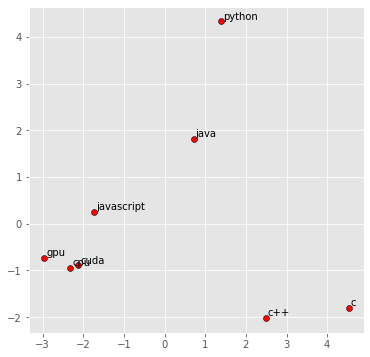

In [46]:
display_pca_scatterplot(model, ['python', 'java', 'javascript', 'c', 'c++', 'cuda', 'gpu', 'cpu'])